In [75]:
#ke sso akun d3
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import librosa
import numpy as np
import pywt
from scipy import signal

In [0]:
import tensorflow as tf, tensorflow.keras.backend as K
import tensorflow_addons as tfa
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [78]:


DataTrain="/content/drive/My Drive/DataSetSuaraJantungPhysionet/Dataset/DatasetListTrain.txt"
DataTrainLabel="/content/drive/My Drive/DataSetSuaraJantungPhysionet/Dataset/DatasetLabelTrain.txt"

DataValidLabel="/content/drive/My Drive/DataSetSuaraJantungPhysionet/Dataset/DatasetLabelVal.txt"
DataVal="/content/drive/My Drive/DataSetSuaraJantungPhysionet/Dataset/DatasetListVal.txt"

#train

g=open(DataTrainLabel, "r")

preDataT=[]
preLabelT=[]

for x in g:
  preLabelT.append(x.strip('\n'))
g.close()


#validation

preLabelV=[]

a=open(DataValidLabel, "r")
for x in a:
  preLabelV.append(x.strip('\n'))
a.close()


labelV=np.array(preLabelV)
labelV=labelV.astype(int)

labelT=np.array(preLabelT)
labelT=labelT.astype(int)


print(labelV.shape[0],labelT.shape[0])

301 3240


In [79]:
dir_training="/content/drive/My Drive/DataSetSuaraJantungPhysionet/Dataset/eigenDataTrain.npy"
dir_validation="/content/drive/My Drive/DataSetSuaraJantungPhysionet/Dataset/eigenDataValid.npy"

dirlabel_t="/content/drive/My Drive/DataSetSuaraJantungPhysionet/Dataset/LABELTRAIN.npy"
dirlabel_v="/content/drive/My Drive/DataSetSuaraJantungPhysionet/Dataset/LABELVAL.npy"


training=np.load(dir_training)
training=np.reshape(training,(-1,130,100,1))
label_t=np.load(dirlabel_t)

validation=np.load(dir_validation)
validation=np.reshape(validation,(-1,130,100,1))
label_v=np.load(dirlabel_v)

print(validation.shape)

(301, 130, 100, 1)


In [0]:
dataSize=[130, 100]
EPOCHS=15
BATCH_SIZE = 32

CLASSES=['Tidak Normal','Normal']       

In [0]:
#learning rate scheduler

LR_START = 0.0001
LR_MAX =  0.00005 
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 6
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = np.random.random_sample() * LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [0]:
# import efficientnet.keras as efn 

pretrained_model=tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, weights=None,  input_shape=[*dataSize, 1])
pretrained_model.trainable = True # False = transfer learning, True = fine-tuning
      
model = tf.keras.Sequential([
          pretrained_model,
          tf.keras.layers.Dropout(0.35),
          tf.keras.layers.GlobalAveragePooling2D(),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(1, activation='sigmoid')
      ])

In [83]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 5, 4, 2048)        23558528  
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 4, 2048)        0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049      
Total params: 23,560,577
Trainable params: 23,515,137
Non-trainable params: 45,440
_________________________________________________________________


In [0]:
radam = tfa.optimizers.RectifiedAdam()

model.compile(
    # optimizer='adam',
    optimizer= tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.55),
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

In [85]:

model.fit( x=training,y=label_t,validation_data=(validation,label_v), epochs=EPOCHS,callbacks=[lr_callback],
          use_multiprocessing=False)


Epoch 00001: LearningRateScheduler reducing learning rate to 6.995472063421296e-05.
Epoch 1/15
102/102 [==============================] - 17s 165ms/step - loss: 0.5787 - accuracy: 0.6716 - val_loss: 0.6993 - val_accuracy: 0.4983 - lr: 6.9955e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 2.9884230447591155e-05.
Epoch 2/15
102/102 [==============================] - 16s 157ms/step - loss: 0.3859 - accuracy: 0.8540 - val_loss: 0.8206 - val_accuracy: 0.4983 - lr: 2.9884e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 6.548809111671015e-05.
Epoch 3/15
102/102 [==============================] - 16s 161ms/step - loss: 0.3342 - accuracy: 0.8673 - val_loss: 0.8384 - val_accuracy: 0.5316 - lr: 6.5488e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 1.7506586686338422e-06.
Epoch 4/15
102/102 [==============================] - 16s 160ms/step - loss: 0.2960 - accuracy: 0.8824 - val_loss: 0.6512 - val_accuracy: 0.6545 - lr: 1.7507e-06

Epoch 000

In [0]:
#1 normal
#0 tidak normal
Xnew = model.predict_classes(validation)
for i in range(len(Xnew)):
	print("X=%s, Predicted=%s" % (label_v[i], Xnew[i]))

In [144]:
"""Confusion Matrix, For Model Benchmark"""
yPredict = model.predict_classes(validation)
yPredict=np.transpose(yPredict)
yPredict=yPredict.flatten()

print("Predicted Label: ",yPredict[:20])
print("Correct Label: ",label_v[:20])

cmatrix= confusion_matrix(label_v, yPredict, labels=[0,1])
print(cmatrix)

Predicted Label:  [1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 0 1]
Correct Label:  [1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 0 1]
[[150   0]
 [ 12 139]]


In [130]:
#metric
score = f1_score(label_v, yPredict, labels=[0,1], average='macro')
precision = precision_score(label_v, yPredict,  labels=[0,1], average='macro')
recall = recall_score(label_v, yPredict,  labels=[0,1], average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized

print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

f1 score: 0.960, precision: 0.963, recall: 0.960


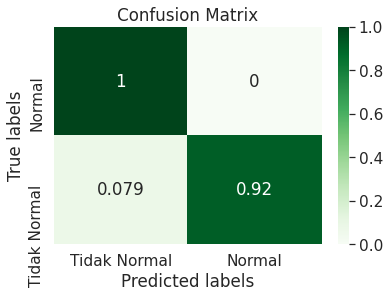

In [145]:
#visual confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cmat,cmap='Greens', annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tidak Normal', 'Normal']); 
ax.yaxis.set_ticklabels(['Normal', 'Tidak Normal']);